In [16]:
import os
import glob

import torch
from torch.utils.data import Dataset
from scipy import signal
from scipy.io import wavfile
import cv2
from PIL import Image
import numpy as np

In [2]:
class Synth90kDataset(Dataset):
    CHARS = '0123456789abcdefghijklmnopqrstuvwxyz'
    CHAR2LABEL = {char: i + 1 for i, char in enumerate(CHARS)}
    LABEL2CHAR = {label: char for char, label in CHAR2LABEL.items()}

    def __init__(self, root_dir=None, mode=None, paths=None, img_height=32, img_width=100):
        if root_dir and mode and not paths:
            paths, texts = self._load_from_raw_files(root_dir, mode)
        elif not root_dir and not mode and paths:
            texts = None

        self.paths = paths
        self.texts = texts
        self.img_height = img_height
        self.img_width = img_width

    def _load_from_raw_files(self, root_dir, mode):
        mapping = {}
        with open(os.path.join(root_dir, 'lexicon.txt'), 'r') as fr:
            for i, line in enumerate(fr.readlines()):
                mapping[i] = line.strip()

        paths_file = None
        if mode == 'train':
            paths_file = 'annotation_train.txt'
        elif mode == 'dev':
            paths_file = 'annotation_val.txt'
        elif mode == 'test':
            paths_file = 'annotation_test.txt'

        paths = []
        texts = []
        with open(os.path.join(root_dir, paths_file), 'r') as fr:
            for line in fr.readlines():
                path, index_str = line.strip().split(' ')
                path = os.path.join(root_dir, path)
                index = int(index_str)
                text = mapping[index]
                paths.append(path)
                texts.append(text)
        return paths, texts

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]

        try:
            image = Image.open(path).convert('L')  # grey-scale
        except IOError:
            print('Corrupted image for %d' % index)
            return self[index + 1]

        image = image.resize((self.img_width, self.img_height), resample=Image.BILINEAR)
        image = np.array(image)
        image = image.reshape((1, self.img_height, self.img_width))
        image = (image / 127.5) - 1.0

        image = torch.FloatTensor(image)
        if self.texts:
            text = self.texts[index]
            target = [self.CHAR2LABEL[c] for c in text]
            target_length = [len(target)]

            target = torch.LongTensor(target)
            target_length = torch.LongTensor(target_length)
            # 如果DataLoader不设置collate_fn,则此处返回值为迭代DataLoader时取到的值
            return image, target, target_length
        else:
            return image


In [3]:
def synth90k_collate_fn(batch):
    # zip(*batch)拆包
    images, targets, target_lengths = zip(*batch)
    # stack就是向量堆叠的意思。一定是扩张一个维度，然后在扩张的维度上，把多个张量纳入仅一个张量。想象向上摞面包片，摞的操作即是stack，0轴即按块stack
    images = torch.stack(images, 0)
    # cat是指向量拼接的意思。一定不扩张维度，想象把两个长条向量cat成一个更长的向量。
    targets = torch.cat(targets, 0)
    target_lengths = torch.cat(target_lengths, 0)
    # 此处返回的数据即使train_loader每次取到的数据，迭代train_loader，每次都会取到三个值，即此处返回值。
    return images, targets, target_lengths

In [4]:
from torch.utils.data import DataLoader
from config import train_config as config

In [5]:
img_width = config['img_width']
img_height = config['img_height']
data_dir = config['data_dir']
train_batch_size = config['train_batch_size']
cpu_workers = config['cpu_workers']

In [6]:
train_dataset = Synth90kDataset(root_dir=data_dir, mode='train',
                                    img_height=img_height, img_width=img_width)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=cpu_workers,
    collate_fn=synth90k_collate_fn)

In [25]:
train_data = train_dataset.__getitem__(136)

In [26]:
print(f'train_data的类型是：{type(train_data)}')
print(f'train_data的长度是：{len(train_data)}')

train_data的类型是：<class 'tuple'>
train_data的长度是：3


In [27]:
train_data

(tensor([[[0.3020, 0.2941, 0.2863,  ..., 0.2941, 0.2863, 0.3020],
          [0.3020, 0.2941, 0.2863,  ..., 0.2941, 0.2941, 0.2941],
          [0.3020, 0.2941, 0.2863,  ..., 0.2941, 0.3020, 0.2941],
          ...,
          [0.2941, 0.3020, 0.3020,  ..., 0.2941, 0.2941, 0.2941],
          [0.3020, 0.2863, 0.3020,  ..., 0.2941, 0.2941, 0.2941],
          [0.3176, 0.2784, 0.3020,  ..., 0.2941, 0.2941, 0.2941]]]),
 tensor([14, 15, 30, 15, 28, 23, 19, 24, 11, 24, 30, 29]),
 tensor([12]))

In [28]:
img = train_data[0]
label_idx = train_data[1]
label_length = train_data[2]

In [29]:
print(f'img的类型是：{type(img)}')
print(f'img的shape是：{img.shape}')
print('img matrix如下:')
print(img)

img的类型是：<class 'torch.Tensor'>
img的shape是：torch.Size([1, 32, 100])
img matrix如下:
tensor([[[0.3020, 0.2941, 0.2863,  ..., 0.2941, 0.2863, 0.3020],
         [0.3020, 0.2941, 0.2863,  ..., 0.2941, 0.2941, 0.2941],
         [0.3020, 0.2941, 0.2863,  ..., 0.2941, 0.3020, 0.2941],
         ...,
         [0.2941, 0.3020, 0.3020,  ..., 0.2941, 0.2941, 0.2941],
         [0.3020, 0.2863, 0.3020,  ..., 0.2941, 0.2941, 0.2941],
         [0.3176, 0.2784, 0.3020,  ..., 0.2941, 0.2941, 0.2941]]])


In [30]:
import matplotlib.pyplot as plt

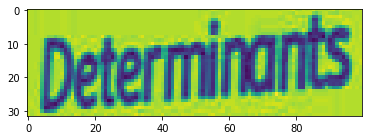

In [31]:
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)
plt.show()

In [32]:
chars = '0123456789abcdefghijklmnopqrstuvwxyz'
label = ''
for idx in label_idx:
    label += chars[idx-1]
print(f'label为：{label}')

label为：determinants
